# Circle Dataset with Diffusion Model

本 notebook 演示如何使用 Diffusion 模型学习圆的数据生成：给定半径 z，生成 (x,y) 坐标点。

## 数据集说明
- **circle.py**: z ~ Uniform[0, 2] (半径)
- **数据生成**: x = z cos(t), y = z sin(t), t ~ Uniform[0, 2π]
- **噪声**: 可选的 Gaussian 噪声 (NOISE_SIGMA)
- **任务**: 学习 p(y=(x,y) | z), 即给定 z 生成 y


## 1. 项目路径设置

设置 Python 路径以正确导入模块。


In [1]:
from pathlib import Path
import sys
# Project path setup
project_root = Path.cwd()
if (project_root / 'src').exists():
    pass
else:
    # Fallback: user-specific path
    project_root = Path('/home/chu034/Yaohang_Li/cDiff')


if not project_root.exists() or not (project_root / 'src').exists():
    raise FileNotFoundError(f"找不到项目目录或 src: {project_root}")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"项目路径: {project_root}")
print("Python 路径已更新")


项目路径: /home/chu034/Yaohang_Li/cDiff
Python 路径已更新


## 2. 导入依赖

导入所需的库和模型。


## 3. 配置参数

设置数据集、模型和训练的超参数。


## 4. 加载 circle 数据集

使用 circle 数据集生成器，设置可选的 (x,y) 噪声。


## 5. 初始化模型

**注意**: 这里模型学习的是 p(y=(x,y) | z)，即给定半径 z 生成 (x,y) 坐标。
- `x_dim = 2`: 生成维度（生成 (x,y)）
- `y_dim_cond = 1`: 条件维度（条件 z）
- `loss(x=y, y=theta)`: 训练时用 y 作为目标，theta(z) 作为条件


## 6. 训练循环

训练模型学习 p(y|z) 分布。每个 epoch 结束后重置 batch sample sizes。


In [2]:
# Notebook-ready minimal training for circle dataset
# CHANGED: converted script to runnable notebook; dataset set to circle
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from datasets import load_dataset
from models.neural_sampler import NormalizingFlowPosteriorSampler, DiffusionPosteriorSampler
from utils import *

# ===== Config (edit here) =====
DATASET = "circle"  # CHANGED: use circle dataset
MODEL = "Diffusion"  # "NormalizingFlow" or "Diffusion"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 1000
N_BATCHES = 200
BATCH_SIZE = 512
LR = 1e-3
LR_DECAY = False
ALPHA = 0.1
USE_ENCODER = False
NUM_HIDDEN_LAYER = 4
SAVE_DIR = "./test"

# CHANGED: set Gaussian noise on (x, y)
from datasets.circle import set_circle_noise_sigma
NOISE_SIGMA = 0.05  # std of noise added to (x,y)
set_circle_noise_sigma(NOISE_SIGMA)

# ===== Load circle dataset =====
# CHANGED: load circle via registry instead of CLI args
dataset_generator, sample_theta, sample_data = load_dataset(DATASET)
if USE_ENCODER:
    dl = dataset_generator(N_BATCHES, BATCH_SIZE, return_ds=False)
else:
    dl = dataset_generator(N_BATCHES, BATCH_SIZE, n_sample=1, return_ds=False)


/tmp/ipykernel_2594714/3326825447.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 7. 测试：给定 z=2 生成 (x,y) 坐标

使用训练好的模型，给定 z=2 生成 500 个 (x,y) 坐标点。


## 8. 可视化生成的圆

- **红虚线**: 理想圆 r=2
- **散点**: 模型生成的 (x,y) 坐标 | z=2


In [3]:
theta, y = next(iter(dl))
y_dim = y.shape[-1]          # 2 (x,y)
theta_dim = theta.shape[1]   # 1 (z)

# learn p(y | z): condition=z (1), generate y=(x,y) (2)
x_dim = y_dim               # generate (x,y)
y_dim_cond = theta_dim      # condition z

if MODEL == "NormalizingFlow":
    model = NormalizingFlowPosteriorSampler(
        y_dim=y_dim_cond,
        x_dim=x_dim,
        n_summaries=256,
        hidden_dim_decoder=32,
        n_flows_decoder=32,
        alpha=ALPHA,
        device=DEVICE,
        use_encoder=USE_ENCODER,
        data_type="iid",
    ).to(DEVICE)
elif MODEL == "Diffusion":
    sigma_data = 0.5
    model = DiffusionPosteriorSampler(
        y_dim=y_dim_cond,
        x_dim=x_dim,
        n_summaries=256,
        num_hidden_layer=NUM_HIDDEN_LAYER,
        device=DEVICE,
        use_encoder=USE_ENCODER,
        data_type="iid",
        sigma_data=sigma_data,
    )
else:
    raise NotImplementedError

# ===== Optimizer/Scheduler =====
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# ===== Recreate DL with dataset object for reset =====
# CHANGED: request ds so we can call reset_batch_sample_sizes per epoch
dl, ds = dataset_generator(N_BATCHES, BATCH_SIZE, None if USE_ENCODER else 1, return_ds=True)


In [4]:

# ===== Training Loop =====
loss_record = []
training_time_record = []
for epoch in range(EPOCHS):
    start_time = time.time()
    epoch_loss = []

    for batch in dl:
        theta, y = batch
        if y.shape[1] == 1:
            y = y.squeeze(1)
        y = y.to(DEVICE)
        theta = theta.to(DEVICE)

        optimizer.zero_grad()
        loss = model.loss(x=y, y=theta).mean()
        epoch_loss.append(float(loss))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=100.0)
        optimizer.step()

    if LR_DECAY:
        scheduler.step()

    # CHANGED: reset sample sizes per epoch for streaming circle data
    ds.reset_batch_sample_sizes()

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss {np.mean(epoch_loss):.4f}  LR {scheduler.get_last_lr()[0]:.6f}")
    loss_record.append(np.mean(epoch_loss))
    training_time_record.append(time.time() - start_time)


/tmp/ipykernel_2594714/1762256242.py:17: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  epoch_loss.append(float(loss))


Epoch 1/1000  Loss 1.2006  LR 0.001000
Epoch 2/1000  Loss 1.0734  LR 0.001000
Epoch 3/1000  Loss 1.0121  LR 0.001000
Epoch 4/1000  Loss 0.9936  LR 0.001000
Epoch 5/1000  Loss 0.9909  LR 0.001000
Epoch 6/1000  Loss 0.9847  LR 0.001000
Epoch 7/1000  Loss 0.9875  LR 0.001000
Epoch 8/1000  Loss 0.9851  LR 0.001000
Epoch 9/1000  Loss 0.9834  LR 0.001000
Epoch 10/1000  Loss 0.9816  LR 0.001000
Epoch 11/1000  Loss 0.9894  LR 0.001000
Epoch 12/1000  Loss 0.9782  LR 0.001000
Epoch 13/1000  Loss 0.9823  LR 0.001000
Epoch 14/1000  Loss 0.9837  LR 0.001000
Epoch 15/1000  Loss 0.9826  LR 0.001000
Epoch 16/1000  Loss 0.9774  LR 0.001000
Epoch 17/1000  Loss 0.9833  LR 0.001000
Epoch 18/1000  Loss 0.9833  LR 0.001000
Epoch 19/1000  Loss 0.9706  LR 0.001000
Epoch 20/1000  Loss 0.9899  LR 0.001000
Epoch 21/1000  Loss 0.9765  LR 0.001000
Epoch 22/1000  Loss 0.9821  LR 0.001000
Epoch 23/1000  Loss 0.9805  LR 0.001000
Epoch 24/1000  Loss 0.9763  LR 0.001000
Epoch 25/1000  Loss 0.9851  LR 0.001000
Epoch 26/

In [24]:
import torch
import numpy as np

with torch.no_grad():
    N = 500
    z_cond = torch.full((N, 1), 2.0, device=DEVICE)  # 只输入 z=2
    y_gen = model.sample(z_cond, num_steps=18).cpu().numpy()  # (N, 2)

print("y_gen shape:", y_gen.shape)

y_gen shape: (500, 2)


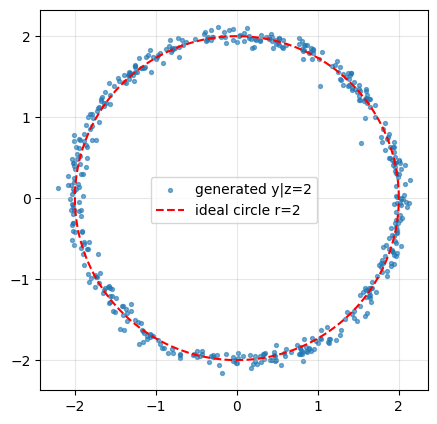

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_gen[:,0], y_gen[:,1], s=8, alpha=0.6, label='generated y|z=2')
tt = np.linspace(0, 2*np.pi, 400)
plt.plot(2*np.cos(tt), 2*np.sin(tt), 'r--', label='ideal circle r=2')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()